In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandahouse as ph
from scipy import stats
import matplotlib.pyplot as plt
import os
#импортируем необходимые модули

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': os.environ['KC_PASSWORD'],
    'user': 'student',
    'database': 'simulator_20221120'
}

q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

df1 = ph.read_clickhouse(q, connection=connection) #подключаемся к базе данных и копируем необходимые данные в DataFrame

In [4]:
#скопируем данные второго AB-теста в другой DataFrame
q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
'''

df2 = ph.read_clickhouse(q, connection=connection) 

In [5]:
#считаем CTR контрольных групп
control_ctr_1 = df1[df1.exp_group == 1].likes.sum() / df1[df1.exp_group == 1].views.sum()
control_ctr_2 = df2[df2.exp_group == 0].likes.sum() / df2[df2.exp_group == 0].views.sum()

In [6]:
#считаем поюзерные линеаризованные лайки
df1['linearized_likes'] = df1.likes - df1.views * control_ctr_1
df2['linearized_likes'] = df2.likes - df2.views * control_ctr_2

In [7]:
p_ctr_1 = stats.ttest_ind(df1[df1.exp_group == 1].ctr, df1[df1.exp_group == 2].ctr, equal_var=False)[1]
p_linearized_1 = stats.ttest_ind(df1[df1.exp_group == 1].linearized_likes, df1[df1.exp_group == 2].linearized_likes, equal_var=False)[1]
print(f'P-значение теста по CTR: {p_ctr_1:.3}, по линеаризованным лайкам: {p_linearized_1:.3}')

P-значение теста по CTR: 0.478, по линеаризованным лайкам: 9.44e-10


P-значение теста по линеаризованным лайкам значительно меньше, использование этой метрики предотвратило принятие неверной нулевой гипотезы

In [8]:
p_ctr_2 = stats.ttest_ind(df2[df2.exp_group == 0].ctr, df2[df2.exp_group == 3].ctr, equal_var=False)[1]
p_linearized_2 = stats.ttest_ind(df2[df2.exp_group == 0].linearized_likes, df2[df2.exp_group == 3].linearized_likes, equal_var=False)[1]
print(f'P-значение теста по CTR: {p_ctr_2:.3}, по линеаризованным лайкам: {p_linearized_2:.3}')

P-значение теста по CTR: 1.06e-43, по линеаризованным лайкам: 5.49e-52


P-значение также меньше для теста по линеаризованным лайкам, но это не влияет на отклонение или принятие нулевой гипотезы из-за того, что распределение CTR довольно близко к нормальному

Также визуализируем распределение CTR и линеаризованных лайков в обоих экспериментах

Text(0, 0.5, 'AB-тест 2')

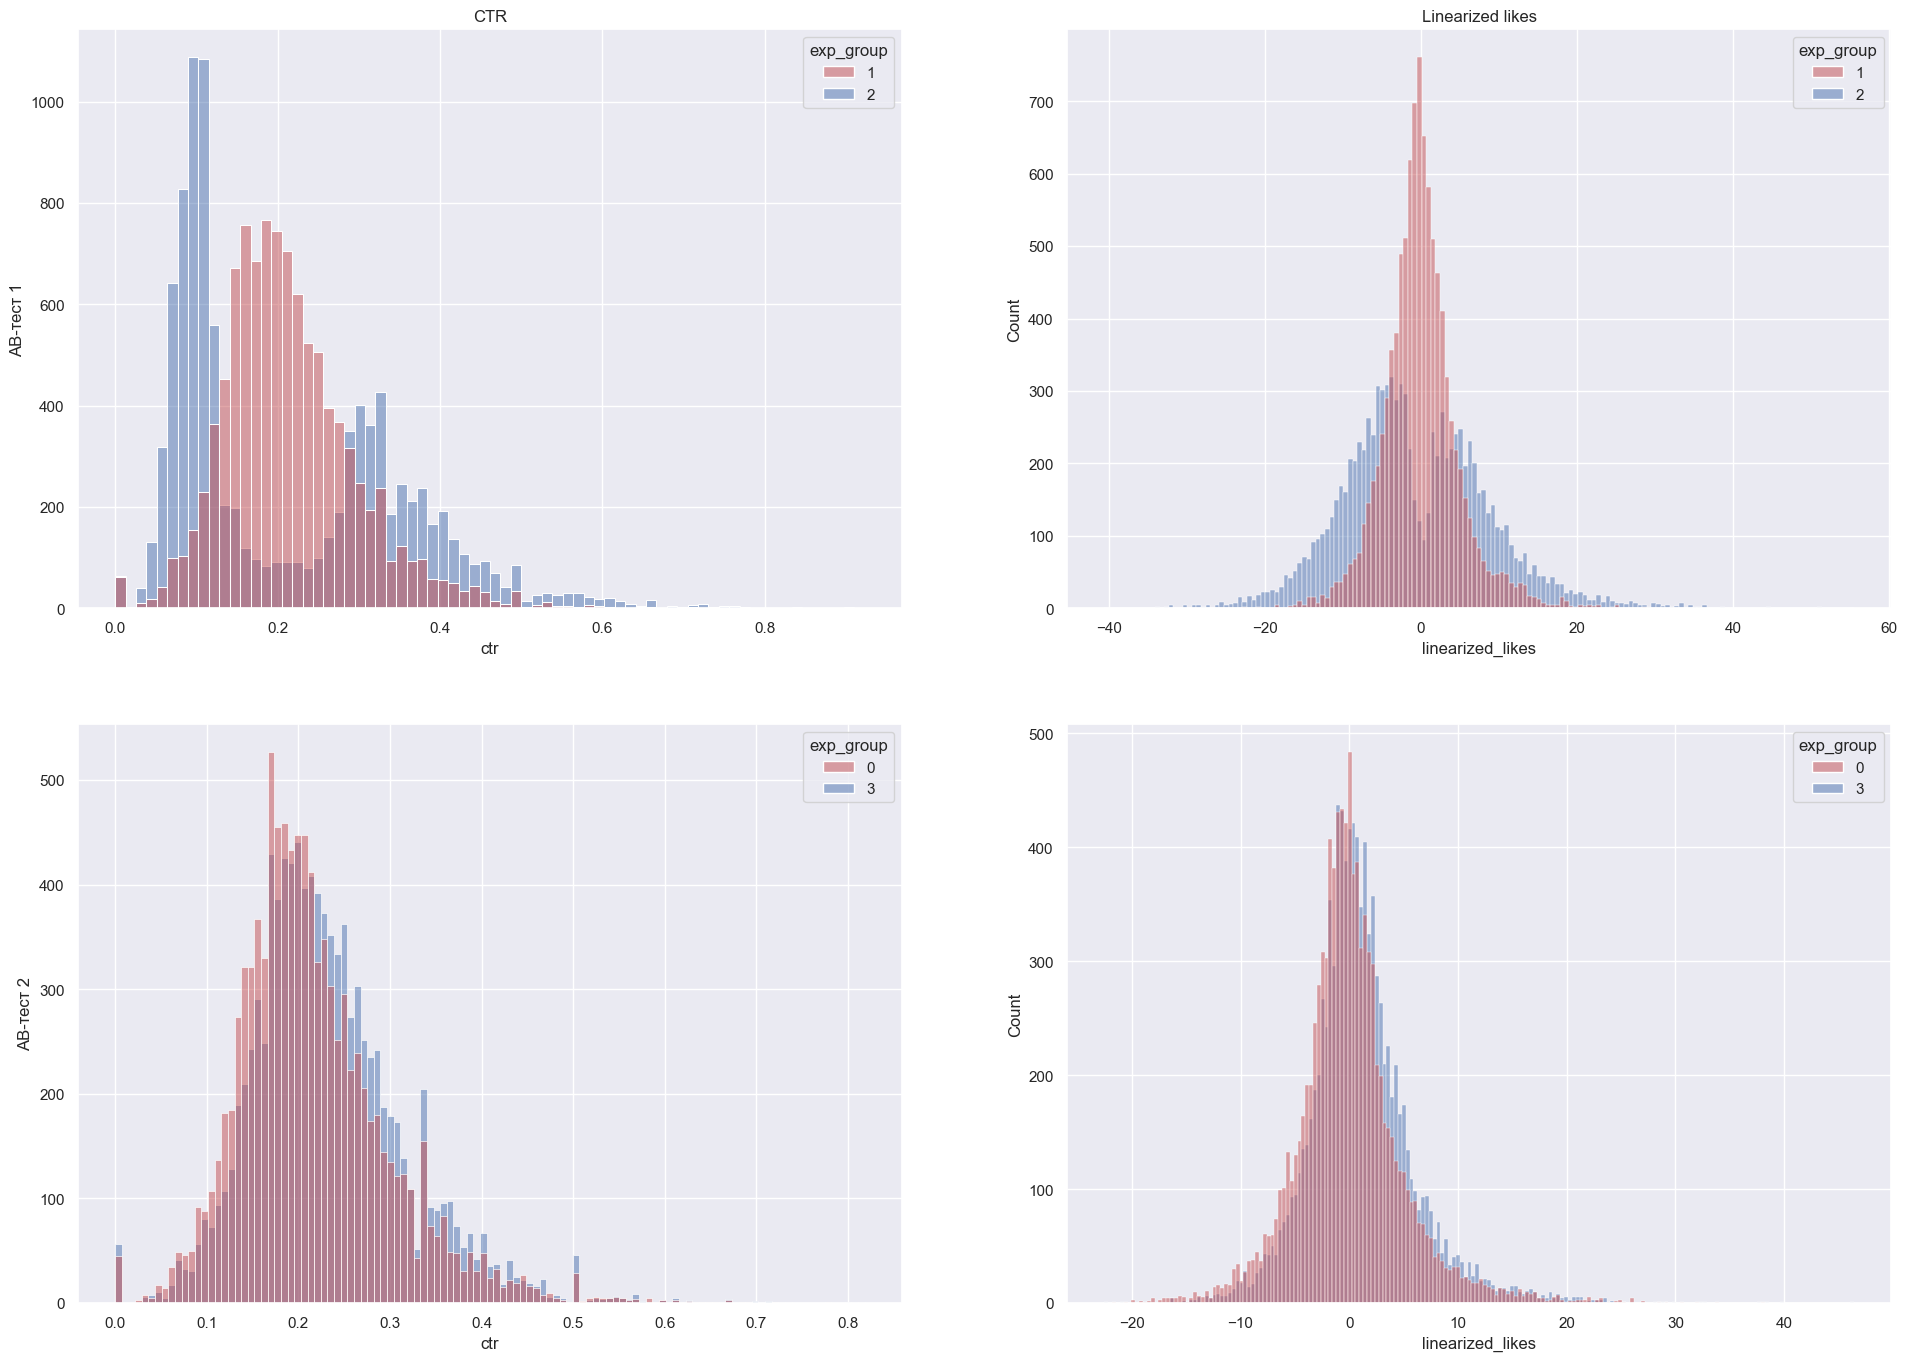

In [9]:
sns.set(rc={'figure.figsize':(23.4,16.54)}) #делаем графики покрупнее
fig, ax = plt.subplots(nrows=2, ncols=2)
sns.histplot(data = df1, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              ax=ax[0,1])
sns.histplot(data = df1, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              ax=ax[0,0])
sns.histplot(data = df2, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              ax=ax[1,1])
sns.histplot(data = df2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              ax=ax[1,0])
ax[0, 0].set_title('CTR')
ax[0, 1].set_title('Linearized likes')
ax[0, 0].set_ylabel('AB-тест 1')
ax[1, 0].set_ylabel('AB-тест 2')

Как видно из гистограмм, использование линеаризованных лайков помогает в какой-то мере избавиться от "испорченности" распределения нашей метрики